# Description

In this Python Notebook, we implement a non-unitary operator in a quantum circuit and test its functioning with the appropriate mathematical justification. We obtain the method from Lin et al. (2021).

# Method

We try to implement the controlled non-unitary operation as follows:
\begin{align*}
    M_{ij} &= |0 \rangle \langle 0|_j \otimes I_i +   |1 \rangle \langle 1|_j \otimes U_{ij} \\
    U_{ij} &= \begin{bmatrix} \sqrt{1-a_{ij}} && 0 \\ \sqrt{a_{ij}} && 1 \end{bmatrix}
\end{align*}

Where $a_{ij}$ represents the probability of system $i$ failing given that system $j$ fails $P(s_i(t+ \Delta t)=1 | s_j(t)=1 \text{ and } s_i(t) = 0)$. In the language of quantum operators, we apply the operation $U_{ij}$ on qubit $|q_i\rangle$ with a control on qubit $|q_j\rangle$. Thus, if the system $s_i$ is in state $(a,b)^T$ and $s_j$ in $(c,d)^T$, where $a,c$ are the weights of the probabilities in which the $s_i,s_j$ have not failed, we expect that after the operation, we should get 

\begin{align*}
    (ac) |0\rangle_j \otimes |0\rangle_i & \to (ac) |0\rangle_j \otimes |0\rangle_i \\
    (ad) |1\rangle_j \otimes |0\rangle_i & \to (ad) |0\rangle_j \otimes |0\rangle_i \\
    (bc) |0\rangle_j \otimes |1\rangle_i & \to (bc) |1\rangle_j \otimes (\sqrt{1-a_{ij}} |0\rangle + \sqrt{a_{ij}}|1\rangle) \\
    (cd) |1\rangle_j \otimes |1\rangle_i & \to (ad) |1\rangle_j \otimes |1\rangle_i 
\end{align*}

The code cell belows shows how we expect the operation to work, with various initial superpositions. 

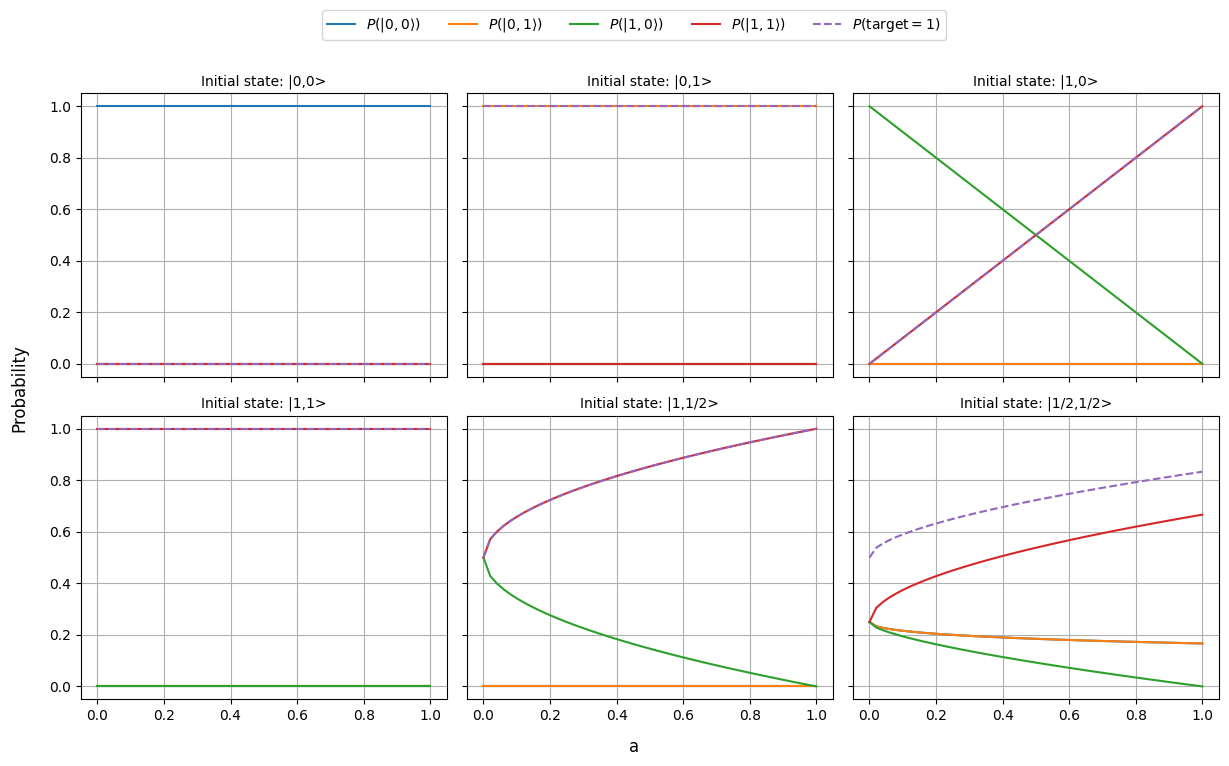

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def controlled_operator(a):
    """
    Returns M_{ij} = |0><0|_j x I_i + |1><1|_j x U_{ij},
    where U_{ij} = [[sqrt(1 - a), 0], [sqrt(a), 1]].
    """
    P0_j = np.array([[1, 0], [0, 0]])  # |0><0|
    P1_j = np.array([[0, 0], [0, 1]])  # |1><1|
    Uij = np.array([
        [np.sqrt(1 - a), 0],
        [np.sqrt(a),     1]
    ])
    return np.kron(P0_j, np.eye(2)) + np.kron(P1_j, Uij)

# Define the states as (j,i) in the basis [|0,0>, |0,1>, |1,0>, |1,1>].
initial_states = {
    "|0,0>":      np.array([1, 0, 0, 0]),
    "|0,1>":      np.array([0, 1, 0, 0]),
    "|1,0>":      np.array([0, 0, 1, 0]),
    "|1,1>":      np.array([0, 0, 0, 1]),
    "|1,1/2>":    np.array([0, 0, 1/np.sqrt(2), 1/np.sqrt(2)]),
    "|1/2,1/2>":  np.array([1/2, 1/2, 1/2, 1/2])
}

# Range of 'a' values
num_points = 50
a_values = np.linspace(0, 1, num_points)

# Create a single figure with subplots; 2 rows x 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.flatten()  # Convert the 2D array of axes to a 1D list

for idx, (state_label, init_vec) in enumerate(initial_states.items()):
    # Collect probabilities for each of the four basis states
    probs_00, probs_01, probs_10, probs_11 = [], [], [], []
    
    for a in a_values:
        Mij = controlled_operator(a)
        final_vec = Mij @ init_vec

        # Probabilities in the basis [|0,0>, |0,1>, |1,0>, |1,1>]
        p_00 = abs(final_vec[0])**2
        p_01 = abs(final_vec[1])**2
        p_10 = abs(final_vec[2])**2
        p_11 = abs(final_vec[3])**2
        norm = (p_00 + p_01 + p_10 + p_11)

        probs_00.append(p_00 / norm)
        probs_01.append(p_01 / norm)
        probs_10.append(p_10 / norm)
        probs_11.append(p_11 / norm)
    
    ax = axes[idx]
    ax.plot(a_values, probs_00, label=r"$P(|0,0\rangle)$")
    ax.plot(a_values, probs_01, label=r"$P(|0,1\rangle)$")
    ax.plot(a_values, probs_10, label=r"$P(|1,0\rangle)$")
    ax.plot(a_values, probs_11, label=r"$P(|1,1\rangle)$")

    # “Failure” line: sum of probabilities where target qubit i = 1
    # i.e. states |0,1> and |1,1>
    ax.plot(a_values,
            np.array(probs_01) + np.array(probs_11),
            linestyle="--",
            label=r"$P(\text{target}=1)$")

    ax.set_title(f"Initial state: {state_label}", fontsize=10)
    ax.grid(True)

# Create a single legend for the entire figure, and add common labels
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.05))
fig.text(0.5, -0.02, "a", ha="center", fontsize=12)
fig.text(-0.02, 0.5, "Probability", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space at top for the legend
plt.show()


When we apply the method we are trying, we are building a matrix with an operation on a system with one extra ancilla qubit, so

\begin{align*}
    |\Psi \rangle = |\Psi\rangle_{\text{main}} \otimes |\Psi\rangle_{\text{ancilla}}
\end{align*}

And, we get the matrix 

\begin{align*}
    M' = \begin{bmatrix} s M_{ij} & C \\ B & D\end{bmatrix}
\end{align*}

where $s^{-2} = 1 + \sqrt a $ is the maximum singular value of $M_{ij}$, and $B,C,D$ are matrices that make $M'$ unitary. More importantly, when the ancilla qubit is $|q_{\text{ancilla}}\rangle = |0\rangle$ we obtain the relationship

\begin{align*}
    M'|\Psi\rangle &= \begin{bmatrix} s M_{ij} |\Psi \rangle_{main}  \\ C |\Psi \rangle_{main}   \end{bmatrix}
\end{align*}

So, to see the effect of $M_{ij}$, up to a factor of $s$, we will need to make the operation $\langle 0|_{\text{ancilla}}$, so

\begin{align*}
    \langle 0|_{\text{ancilla}}M'|\Psi\rangle &=  s M_{ij} |\Psi \rangle_{main} 
\end{align*}

The elements on the left are precisely what we can measure from the quantum circuit. Precisely, we can measure $|\langle 0_{\text{ancilla}}, 1_{i}|M'|\Psi\rangle |^2 = s^2 |\langle 1_i| M_{ij} |\Psi \rangle_{main}|^2 $, which is the probability of the target qubit failing, so we would need to rescale the measurement of probabilities by a factor of $s^{-2} = 1 + \sqrt a$ to obtain the appropriate values of the operation of $M_{ij}$. In the code cell below, we implement such operations

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from scipy.linalg import svd, qr
from qiskit.circuit.library import UnitaryGate  

###############################################################################
# (A) HELPER: DILATE A NON-UNITARY INTO A UNITARY
###############################################################################
def embed_non_unitary(matrix):
    """
    Embed a non-unitary operator (matrix) into a larger 2N x 2N unitary.
    Uses SVD -> scale factor s -> build block matrix -> QR decomposition.
    """
    U_, Sigma, Vh = svd(matrix)
    # Scale = 1 / sqrt(max singular value^2)
    s2 = np.max(Sigma**2)
    s = 1/np.sqrt(s2)

    # Build the "C" block
    Sigma_tilde = np.sqrt(np.maximum(0, 1 - s**2 * Sigma**2))
    C = U_ @ np.diag(Sigma_tilde) @ Vh

    size = matrix.shape[0]
    B_tilde = np.random.rand(size, size)
    D_tilde = np.random.rand(size, size)

    U_tilde = np.block([
        [s * matrix,  B_tilde],
        [      C,    D_tilde]
    ])
    # Convert to a unitary by QR
    UA, _ = qr(U_tilde)
    return UA

###############################################################################
# (B) CIRCUIT-BUILDING / SIMULATION FUNCTION
###############################################################################
def run_circuit(a, psi0, psi1, shots=2000):
    """
    Build a circuit for the 2-main-qubits + 1-ancilla scenario:
      - main[0] = control qubit, initialized to psi0
      - main[1] = target qubit, initialized to psi1
      - anc in |0>
      - non-unitary M_ij depends on 'a'
    Return the probability that qubit-1 is measured = |1>.
    """
    # Create quantum and classical registers
    qreg_main = QuantumRegister(2, 'main')
    qreg_anc = QuantumRegister(1, 'anc')
    creg = ClassicalRegister(3, 'c')  # measure 3 qubits
    qc = QuantumCircuit(qreg_main, qreg_anc, creg)

    # Initialize qubits
    #   psi0 is a 2D array (amps for qubit0)
    #   psi1 is a 2D array (amps for qubit1)
    qc.initialize(psi0, qreg_main[0])  
    qc.initialize(psi1, qreg_main[1])  

    # Construct the 2x2 operator
    #   U_ij = |0><0| + sqrt(a)|1><0| + ...
    U_ij = np.array([
        [np.sqrt(1 - a), 0],
        [np.sqrt(a),     1]
    ], dtype=complex)

    # We only apply this to qubit-1 if it's in |1>, so we do:
    #   M_ij = I \otimes P0 + U_ij \otimes P1
    I2 = np.eye(2, dtype=complex)
    P0 = np.array([[1,0],[0,0]], dtype=complex)
    P1 = np.array([[0,0],[0,1]], dtype=complex)
    M_ij = np.kron(I2, P0) + np.kron(U_ij, P1)

    # Embed into 3-qubit unitary
    big_unitary = embed_non_unitary(M_ij)
    gate = UnitaryGate(big_unitary, label="M'_ij")

    # Append to the circuit on qubits [0,1,2]
    qc.append(gate, [0, 1, 2])

    # Measure qubit0 -> cbit0, qubit1-> cbit1, anc-> cbit2
    qc.measure(qreg_anc,     2)
    qc.measure(qreg_main[0], 0)
    qc.measure(qreg_main[1], 1) # Is the order of measurements the issue?

    # Run simulation
    backend = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, backend)
    job = backend.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    # Probability that qubit1 = |1>
    #   Qiskit returns strings with bits in order cbit2 cbit1 cbit0
    p_q1_1 = sum(c for key, c in counts.items() if key[1] == '1' and key[0] == '0')/shots # project ancilla to |0>
    return p_q1_1

###############################################################################
# (C) CHOOSE FOUR INITIAL STATES FOR (qubit0, qubit1)
#     We'll label them so we can plot multiple lines.
###############################################################################
# "qubit0" = control, "qubit1" = target
# Each qubit is a 2D vector [amp|0>, amp|1>] 
#   => so "10" means qubit0=|1>, qubit1=|0>

# 1) qubit0=|1>, qubit1=|0>
init_10 = (np.array([0, 1], dtype=complex),  # qubit0
           np.array([1, 0], dtype=complex))  # qubit1

# 2) qubit0=|1>, qubit1=|1>
init_11 = (np.array([0, 1], dtype=complex),
           np.array([0, 1], dtype=complex))

# 3) qubit0 = (|0>+|1>)/sqrt(2), qubit1=|0>
init_plus0 = (np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex),
              np.array([1, 0], dtype=complex))

# 4) qubit0 = (|0>+|1>)/sqrt(2), qubit1=(|0>+|1>)/sqrt(2)
init_plus_plus = (
    np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)
)

# Put them in a dictionary for easy looping/plotting:
initial_states = {
    "|1,0>": init_10,
    "|1,1>": init_11,
    "|+_0,0>": init_plus0,
    "|+_0,+_1>": init_plus_plus
}

def controlled_operator(a):
    """
    Returns the 4x4 controlled operator:
        M_{ij} = |0><0|_j x I_i + |1><1|_j x U_{ij},
    where 
        U_{ij} = [[sqrt(1 - a), 0],
                  [sqrt(a),     1]].
    """
    # Projectors on the control qubit j
    P0_j = np.array([[1, 0],
                     [0, 0]])  # |0><0|
    P1_j = np.array([[0, 0],
                     [0, 1]])  # |1><1|

    # 2x2 operator on the target qubit i
    Uij = np.array([
        [np.sqrt(1 - a), 0],
        [np.sqrt(a),     1]
    ])
    
    # Construct the 4x4 operator
    return np.kron(P0_j, np.eye(2)) + np.kron(P1_j, Uij)


def failure_probability(a, j_init, i_init):
    """
    Given:
      - a:       The real parameter in [0,1].
      - j_init:  A length-2 array of amplitudes for the control qubit |j>.
      - i_init:  A length-2 array of amplitudes for the target qubit |i>.

    1) Builds the full initial state |j> ⊗ |i> in a 4D vector.
    2) Applies the 4x4 operator M_{ij}(a).
    3) Returns the (normalized) probability that the final state
       is in the subspace with the target qubit = |1> 
       (i.e., final basis states |0,1> and |1,1>).
    """
    
    # -- 1) Construct the 4D initial state vector in the order [|0,0>, |0,1>, |1,0>, |1,1>] --
    #    If j_init = [α, β] and i_init = [γ, δ], the tensor product is:
    #       |ψ_init> = αγ |0,0> + αδ |0,1> + βγ |1,0> + βδ |1,1>.
    initial_state = np.kron(j_init, i_init)  # shape (4,)

    # -- 2) Compute final state after applying M_{ij}(a) --
    Mij = controlled_operator(a)
    final_state = Mij @ initial_state

    # -- 3) Compute the normalized probability that the target qubit is |1> --
    p_01 = np.abs(final_state[1])**2  # amplitude of |0,1>
    p_11 = np.abs(final_state[3])**2  # amplitude of |1,1>
    norm = np.sum(np.abs(final_state)**2)

    #return (p_01 + p_11) / norm
    return p_01 + p_11 # no need to normalize?

###############################################################################
# (D) LOOP OVER a, COLLECT PLOTS FOR ALL 4 STATES
###############################################################################
a_values = np.linspace(0, 1, 11)
results = {}  # store p(q1=1) for each state vs. a
scaled_results = {}
theoretical_results = {}

for label, (psi0, psi1) in initial_states.items():
    probs = []
    s_probs = []
    t_probs = []
    for a in a_values:
        p = run_circuit(a, psi0, psi1, shots=2000)
        probs.append(p)
        # scaled
        s_probs.append( p * (np.sqrt(a) + 1) if a > 0 else p )  
        # (handle a=0 carefully if needed)

        t_probs.append(failure_probability(a, psi0, psi1))

    results[label] = probs
    scaled_results[label] = s_probs
    theoretical_results[label] = t_probs


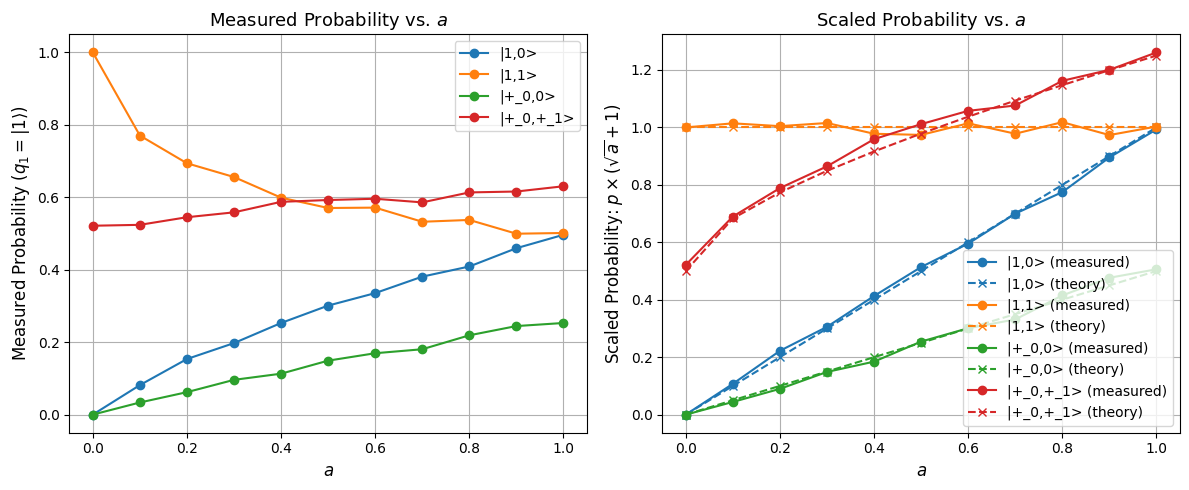

In [6]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# (1) AFTER YOU COLLECT YOUR 'results', 'scaled_results', AND 'theoretical_results'
#     AS YOU ALREADY DO IN THE CODE, YOU CAN MAKE A SINGLE FIGURE WITH SUBPLOTS:
###############################################################################

# Create a 1x2 grid of subplots (side-by-side)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True)

# (A) Left subplot: Measured Probability
# --------------------------------------------------------------
# We'll allow Matplotlib to pick colors from the default color cycle.
# For consistency, let’s store the colors in a list so we can re-use them in the second subplot.
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
labels_list = list(initial_states.keys())  # So we can index them

for idx, label in enumerate(labels_list):
    ax1.plot(a_values,
             results[label],
             marker='o',
             linestyle='-',
             color=color_cycle[idx % len(color_cycle)],
             label=label)

ax1.set_xlabel(r"$a$", fontsize=12)
ax1.set_ylabel(r"Measured Probability $(q_1=|1\rangle)$", fontsize=12)
ax1.set_title("Measured Probability vs. $a$", fontsize=13)
ax1.legend(loc="best")
ax1.grid(True)

# (B) Right subplot: Scaled Probability + Theory
# --------------------------------------------------------------
for idx, label in enumerate(labels_list):
    color = color_cycle[idx % len(color_cycle)]
    
    # Plot scaled measurement
    ax2.plot(a_values,
             scaled_results[label],
             marker='o',
             linestyle='-',
             color=color,
             label=label + " (measured)")
    
    # Plot theory
    ax2.plot(a_values,
             theoretical_results[label],
             marker='x',
             linestyle='--',
             color=color,
             label=label + " (theory)")

ax2.set_xlabel(r"$a$", fontsize=12)
ax2.set_ylabel(r"Scaled Probability: $p \times (\sqrt{a} + 1)$", fontsize=12)
ax2.set_title("Scaled Probability vs. $a$", fontsize=13)
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()


# Conclusion

This shows the operation works exactly as intended when rescaling by a factor of $s^{-2} = 1 + \sqrt a$. Points of consideration:

1. The order of operations is exceedingly important and a lot of care must be taken when applying these operations into the quantum circuit
2. The result after the re-scaling is not normalized, which will likely yield weights out of the range $[0,1]$

After showing this can work for a pair of qubits with varying superpositions, we aim to extend this to utilize more qubits with an adjacency network that predefines the values of $a$.


# References

Lin, S., Dilip, R., Green, A. G., Smith, A., & Pollmann, F. (2021). Real- and Imaginary-Time Evolution with Compressed Quantum Circuits. PRX Quantum, 2(1). https://doi.org/10.1103/prxquantum.2.010342